In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.manifold import TSNE

import plotly.graph_objects as go
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import shap

import csv as csv
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

import os, json
import re

from mplsoccer import Pitch, VerticalPitch
from adjustText import adjust_text
from highlight_text import ax_text
from highlight_text import fig_text
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


import eli5
from eli5.sklearn import PermutationImportance
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Importing other libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Importing libraries for model evaluation 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')



2024-06-17 13:04:38.888614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DIR = "/Users/aritramajumdar/Desktop/The_last_one/ShotData (1).csv"


In [3]:
def read_file(DIR):
    """
    Reads a CSV file from the given directory and returns a DataFrame.

    Parameters:
    DIR (str): Directory path of the CSV file.

    Returns:
    DataFrame: The read DataFrame.
    """
    df = pd.read_csv(DIR)
    return df

def goal_type(df):
    """
    Prints the unique values and the count of the 'play_type' column in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    None
    """
    # Print the unique values in the 'play_type' column
    print(df['play_type'].unique())
    print(df['play_type'].value_counts())
    print(df.columns)


def preprocessing(df):
    """
    Preprocesses the DataFrame by adjusting coordinates and filtering for open play shots.
    It also maps shot outcomes to binary values.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    # Adjust coordinates
    df['x'] = 100.0 - df['position_x']
    df['y'] = 50.0 + df['position_y']
    
    # Filter for open play shots
    df = df.loc[df['play_type'] == 'Open Play']
    df = df.loc[df['outcome'] != 'owngoal']
    
    # Map shot outcomes to binary values
    df['shot_outcome'] = np.where((df['outcome'] == 'Goal'), 'Goal', 'No_Goal')
    mappings = {
        'Goal': 1,
        'No_Goal': 0
    }
    df['shot_outcome'] = df['shot_outcome'].map(mappings)
    
    return df

def distance_calculation(df):
    """
    Calculates distances from the shot location to the goal posts and goal on the field and adds them as new columns.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with new distance columns.
    """
    # Calculate distances to points (100, 46), (100, 54), and (100, 50)
    df['shot_a'] = np.sqrt((df['x']-100)**2 + (df['y']-46)**2) #Distance to the goal post located at (100, 46)
    df['shot_b'] = np.sqrt((df['x']-100)**2 + (df['y']-54)**2) #Distance to the goal post located at (100, 54)
    df['shot_c'] = np.sqrt((df['x']-100)**2 + (df['y']-50)**2) #Distance to the goal 

    # Round distances to 2 decimal places
    df['shot_a'] = df['shot_a'].round(2)
    df['shot_b'] = df['shot_b'].round(2)
    df['shot_c'] = df['shot_c'].round(2)

    return df

def angle_calculation(df):
    """
    Calculates the shot angle using the cosine rule and adds it as a new column.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with the new shot angle column.
    """
    df['shot_angle'] = np.arccos((df['shot_a']**2 + df['shot_b']**2 - 64) / (2 * df['shot_a'] * df['shot_b']))
    df['shot_angle'] = np.degrees(df['shot_angle'])
    df['shot_angle'] = df['shot_angle'].round(2)
    
    return df

def assign_zone(row):
    """
    Assigns a zone to each shot based on its x and y coordinates.

    Parameters:
    row (Series): A row from the DataFrame.

    Returns:
    str: The zone assigned to the shot.
    """
    x, y = row['x'], row['y']
    
    # Define zones based on x and y coordinates
    if 94 < x <= 100 and 46 <= y <= 54:
        return "Zone 1"
    elif 94 < x <= 100 and 54 < y <= 63:
        return "Zone 2"
    elif 94 < x <= 100 and 37 <= y < 46:
        return "Zone 3"
    elif 94 < x <= 100 and 19 <= y < 37:
        return "Zone 4"
    elif 94 < x <= 100 and 63 < y <= 81:
        return "Zone 5"
    elif 88 < x <= 94 and 46 <= y <= 54:
        return "Zone 6"
    elif 88 < x <= 94 and 54 < y <= 63:
        return "Zone 7"
    elif 88 < x <= 94 and 37 <= y < 46:
        return "Zone 8"
    elif 88 < x <= 94 and 19 <= y < 37:
        return "Zone 9"
    elif 88 < x <= 94 and 63 < y <= 81:
        return "Zone 10"
    elif 83 < x <= 88 and 46 <= y <= 54:
        return "Zone 11"
    elif 83 < x <= 88 and 54 < y <= 63:
        return "Zone 12"
    elif 83 < x <= 88 and 37 <= y < 46:
        return "Zone 13"
    elif 83 < x <= 88 and 19 <= y < 37:
        return "Zone 14"
    elif 83 < x <= 88 and 63 < y <= 81:
        return "Zone 15"
    elif 75 < x <= 83 and 37 <= y <= 50:
        return "Zone 16"
    elif 75 < x <= 83 and 50 <= y <= 63:
        return "Zone 17"
    elif 67 <= x <= 75 and 37 <= y < 50:
        return "Zone 18"
    elif 67 <= x <= 75 and 50 <= y <= 63:
        return "Zone 19"
    elif 67 <= x <= 83 and 19 <= y < 37:
        return "Zone 20"
    elif 67 <= x <= 83 and 63 < y <= 81:
        return "Zone 21"
    else:
        return "Other"

def drop_columns(df, unnescessary_columns):
    """
    Drops unnecessary columns from the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.
    unnescessary_columns (list): List of columns to drop.

    Returns:
    DataFrame: The DataFrame with specified columns dropped.
    """
    df = df.drop(unnescessary_columns, axis = 1)
    return df

def cat_to_num(df, fixed_bodypart_mapping, fixed_interference_mapping, fixed_zone_mapping):
    """
    Converts categorical columns to numerical using fixed mappings.

    Parameters:
    df (DataFrame): The input DataFrame.
    fixed_bodypart_mapping (dict): Mapping for BodyPart column.
    fixed_interference_mapping (dict): Mapping for Interference_on_Shooter column.
    fixed_zone_mapping (dict): Mapping for zone column.

    Returns:
    DataFrame: The DataFrame with categorical columns converted to numerical.
    """
    df['BodyPart'] = df['BodyPart'].map(fixed_bodypart_mapping)
    df['Interference_on_Shooter'] = df['Interference_on_Shooter'].map(fixed_interference_mapping)
    df['zone'] = df['zone'].map(fixed_zone_mapping)
    
    return df

def X_y(df, variables, target):
    """
    Splits the DataFrame into features (X) and target (y) variables.

    Parameters:
    df (DataFrame): The input DataFrame.
    variables (list): List of feature columns.
    target (str): The target column.

    Returns:
    DataFrame, Series: The feature DataFrame (X) and target Series (y).
    """
    X = df[variables]
    y = df[target]
    return X, y



def pca(df, X, y):
    """
    Performs PCA on the dataset and plots the first two principal components.

    Parameters:
    df (DataFrame): The input DataFrame.
    X (DataFrame): The feature DataFrame.
    y (Series or array): The target variable.

    Returns:
    None
    """
    # Initialize PCA with 2 components
    pca = decomposition.PCA(n_components=2)
    
    scaler = StandardScaler()
    
    X_values = X.values
    X_scaled = scaler.fit_transform(X_values)
    
    # Fit and transform the feature data
    X_pca = pca.fit_transform(X_scaled)
    
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))
        for lab, col in zip((0, 1),
                            ('lightcoral', 'black')):
            plt.scatter(X_pca[y==lab, 0],
                        X_pca[y==lab, 1],
                        label=lab,
                        c=col)
        plt.xlabel('Principal Component 1', fontsize=16)
        plt.ylabel('Principal Component 2', fontsize=16)
        plt.legend(loc='lower center')
        plt.tight_layout()
        plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/pca.png", dpi=300, bbox_inches='tight')
        plt.show()
    

def tsne(df, X, y):
    """
    Performs t-SNE on the dataset and plots the first two t-SNE components.

    Parameters:
    df (DataFrame): The input DataFrame.
    X (DataFrame): The feature DataFrame.
    y (Series or array): The target variable.

    Returns:
    None
    """
    
    X_values = X.values
    X_scaled = StandardScaler().fit_transform(X_values)
    
    # Initialize t-SNE with 2 components and a fixed random state for reproducibility
    tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
    
    # Fit and transform the feature data using t-SNE
    X_tsne = tsne.fit_transform(X_scaled)
    
    print(tsne.kl_divergence_)
    
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))
        for lab, col in zip((0, 1),
                            ('lightcoral', 'black')):
            plt.scatter(X_tsne[y==lab, 0],
                        X_tsne[y==lab, 1],
                        label=lab,
                        c=col)
        plt.xlabel('First t-SNE Component', fontsize=16)
        plt.ylabel('Second t-SNE Component', fontsize=16)
        plt.legend(loc='lower center')
        plt.tight_layout()
        plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/tsne.png", dpi=300, bbox_inches='tight')
        plt.show()
    


In [4]:
# Reading and preprocessing the data
df = read_file(DIR)
print(df.shape)
goal_type(df)


(10925, 10)
['Open Play' 'Direct freekick' 'Penalty' 'Direct corner' 'Direct Corner']
Open Play          10269
Direct freekick      503
Penalty              148
Direct Corner          4
Direct corner          1
Name: play_type, dtype: int64
Index(['match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'BodyPart', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome'],
      dtype='object')


In [5]:
df = preprocessing(df)
df = distance_calculation(df)
df = angle_calculation(df)
df['zone'] = df.apply(assign_zone, axis=1)

"""------------------"""

# Dropping unnecessary columns
unnescessary_columns = ['play_type', 'match_minute', 'match_second', 'position_x', 'position_y']
df = drop_columns(df, unnescessary_columns)

"""------------------"""

# Define fixed mappings for each unique value in the categorical columns
fixed_bodypart_mapping = {
    'Head': 1, 'Left': 2, 'Right': 3, 'Other': 4  # Example mappings, adjust according to actual unique values
}

fixed_interference_mapping = {
    'Low': 1, 'Medium': 2, 'High': 3  # Example mappings, adjust according to actual unique values
}

fixed_zone_mapping = {
    'Zone 1': 1, 'Zone 2': 2, 'Zone 3': 3, 'Zone 4': 4, 'Zone 5': 5, 'Zone 6': 6, 'Zone 7': 7,
    'Zone 8': 8, 'Zone 9': 9, 'Zone 10': 10, 'Zone 11': 11, 'Zone 12': 12, 'Zone 13': 13, 'Zone 14': 14,
    'Zone 15': 15, 'Zone 16': 16, 'Zone 17': 17, 'Zone 18': 18, 'Zone 19': 19, 'Zone 20': 20, 'Zone 21': 21,
    'Other': 22
}

# Save the mappings for future use
mappings = {
    'bodypart_mapping': fixed_bodypart_mapping,
    'interference_mapping': fixed_interference_mapping,
    'zone_mapping': fixed_zone_mapping
}

# Convert categorical columns to numerical
df = cat_to_num(df, fixed_bodypart_mapping, fixed_interference_mapping, fixed_zone_mapping)

"""------------------"""

# Define feature variables and target variable
variables = ['BodyPart', 'Number_Intervening_Opponents',
             'Number_Intervening_Teammates', 'Interference_on_Shooter',
             'x', 'y', 'shot_angle', 'shot_a', 'shot_b', 'shot_c', 'zone']

target = 'shot_outcome'

# Split the data into features and target
X, y = X_y(df, variables, target)

In [6]:
df

,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,x,y,shot_outcome,shot_a,shot_b,shot_c,shot_angle,zone
0,1,1,0,1,Goal,96.76,49.25,1,4.59,5.75,3.33,100.78,1
1,2,3,0,2,Missed,75.06,50.75,0,25.39,25.15,24.95,18.21,17
2,3,1,0,1,Missed,96.26,49.50,0,5.12,5.85,3.77,93.41,1
4,1,1,0,1,Missed,89.77,54.99,0,13.62,10.28,11.38,35.78,7
5,3,3,1,2,Missed,75.81,50.75,0,24.65,24.41,24.20,18.76,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10920,2,1,2,2,Goal,86.28,54.49,1,16.13,13.73,14.44,29.71,12
10921,1,1,0,2,Goal,90.52,56.24,1,13.95,9.74,11.35,33.93,7
10922,3,3,1,2,Missed,76.06,42.27,0,24.23,26.66,25.16,17.25,16
10923,2,2,0,2,Missed,79.05,58.23,0,24.26,21.37,22.51,18.86,17


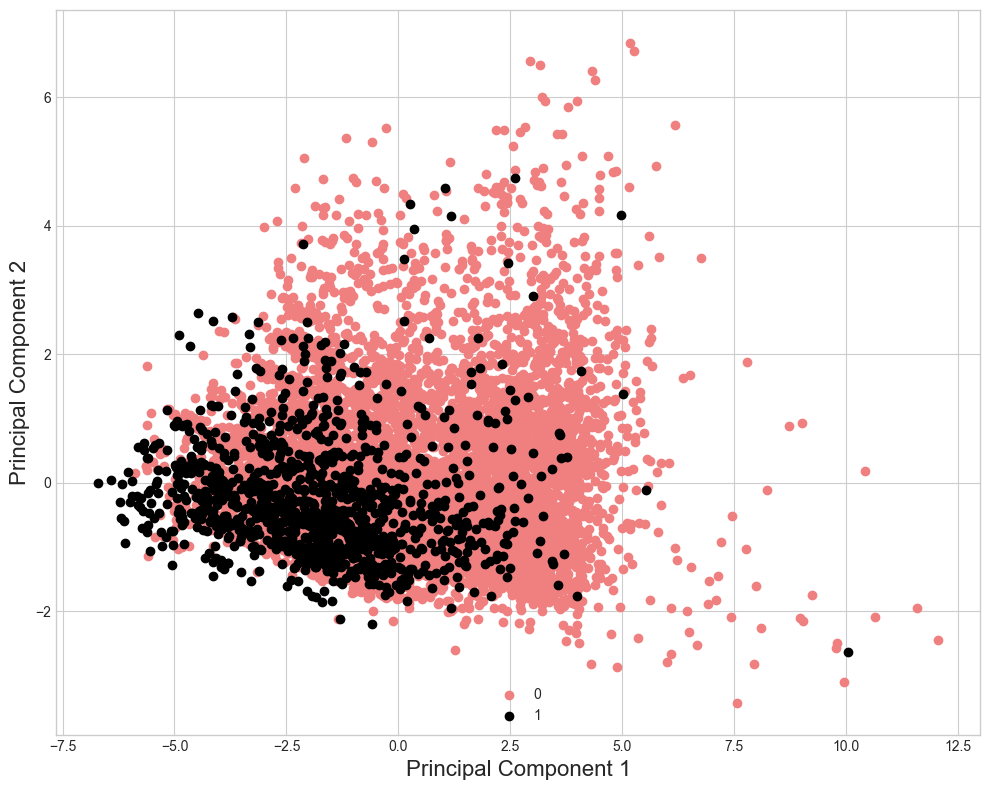

In [7]:
pca(df, X, y)

0.8361397981643677


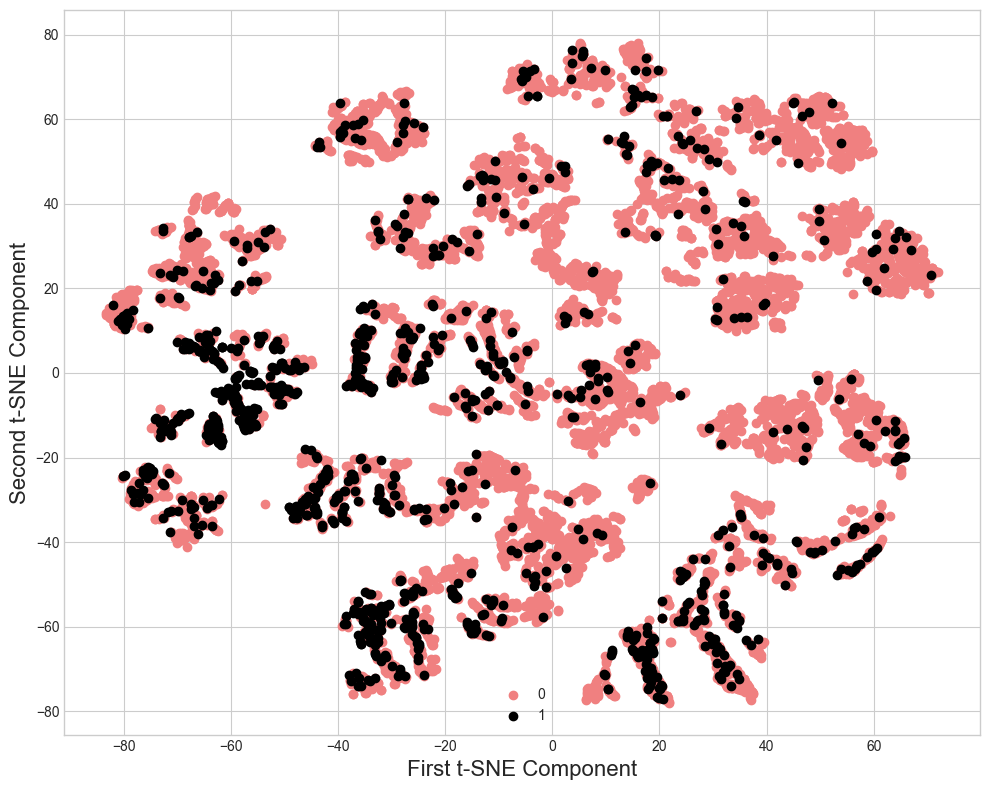

In [8]:
tsne(df, X, y)

In [9]:
goals = df.loc[df['shot_outcome'] == 1]
goals.shape

(1175, 13)

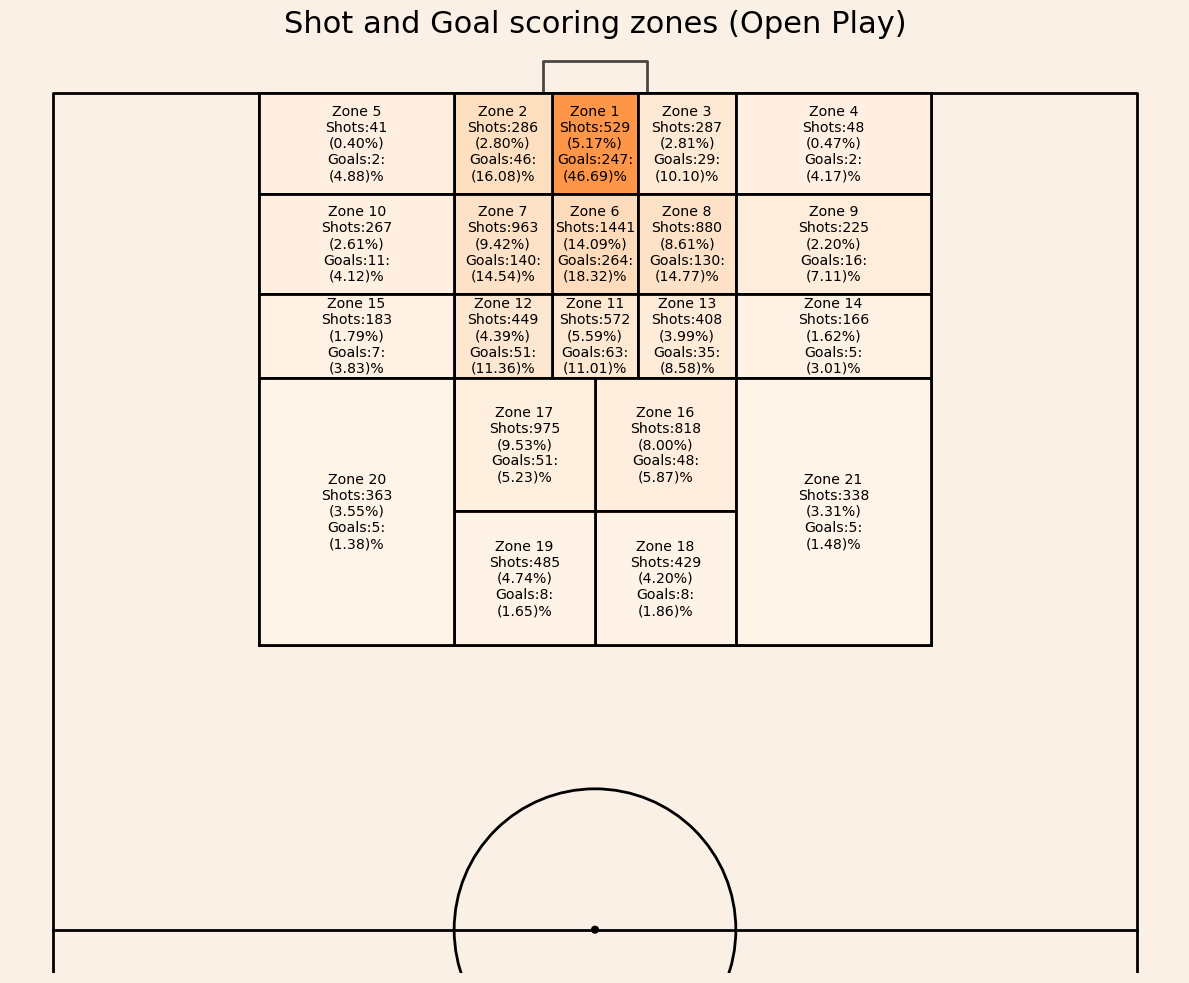

In [10]:
from matplotlib import cm
from matplotlib.colors import Normalize

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import add_image
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import add_image
from datetime import date
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(12, 10), facecolor = 'linen')


pitch = VerticalPitch(pitch_type='opta', pitch_color='linen', 
                      line_color='black', goal_alpha=0.7, half = True, goal_type='box')

# Plot the football pitch
pitch.draw(ax = ax)

# Define the rectangular zones on the pitch
zones = {
    'Zone 1': {'x_min': 94, 'x_max': 100, 'y_min': 46, 'y_max': 54},
    'Zone 2': {'x_min': 94, 'x_max': 100, 'y_min': 54, 'y_max': 63},
    'Zone 3': {'x_min': 94, 'x_max': 100, 'y_min': 37, 'y_max': 46},
    'Zone 4': {'x_min': 94, 'x_max': 100, 'y_min': 19, 'y_max': 37},
    'Zone 5': {'x_min': 94, 'x_max': 100, 'y_min': 63, 'y_max': 81},
    'Zone 6': {'x_min': 88, 'x_max': 94, 'y_min': 46, 'y_max': 54},
    'Zone 7': {'x_min': 88, 'x_max': 94, 'y_min': 54, 'y_max': 63},
    'Zone 8': {'x_min': 88, 'x_max': 94, 'y_min': 37, 'y_max': 46},
    'Zone 9': {'x_min': 88, 'x_max': 94, 'y_min': 19, 'y_max': 37},
    'Zone 10': {'x_min': 88, 'x_max': 94, 'y_min': 63, 'y_max': 81},
    'Zone 11': {'x_min': 83, 'x_max': 88, 'y_min': 46, 'y_max': 54},
    'Zone 12': {'x_min': 83, 'x_max': 88, 'y_min': 54, 'y_max': 63},
    'Zone 13': {'x_min': 83, 'x_max': 88, 'y_min': 37, 'y_max': 46},
    'Zone 14': {'x_min': 83, 'x_max': 88, 'y_min': 19, 'y_max': 37},
    'Zone 15': {'x_min': 83, 'x_max': 88, 'y_min': 63, 'y_max': 81},
    
    'Zone 16': {'x_min': 75, 'x_max': 83, 'y_min': 37, 'y_max': 50},
    'Zone 17': {'x_min': 75, 'x_max': 83, 'y_min': 50, 'y_max': 63},
    
    'Zone 18': {'x_min': 67, 'x_max': 75, 'y_min': 37, 'y_max': 50},
    'Zone 19': {'x_min': 67, 'x_max': 75, 'y_min': 50, 'y_max': 63},
    
    'Zone 20': {'x_min': 67, 'x_max': 83, 'y_min': 63, 'y_max': 81},
    'Zone 21': {'x_min': 67, 'x_max': 83, 'y_min': 19, 'y_max': 37},
    
    
    
}

# Normalize the percentages to be in the range [0, 1] for the colormap
norm = Normalize(vmin=0, vmax=100)

# Choose a colormap (you can use any colormap from Matplotlib)
cmap = cm.get_cmap('Oranges')

for zone, limits in zones.items():
    
    """--------------------"""
    
    zone_shots = df[(df['x'] >= limits['x_min']) & (df['x'] <= limits['x_max']) &
                    (df['y'] >= limits['y_min']) & (df['y'] <= limits['y_max'])]

    total_shots = len(zone_shots)
    percentage = (total_shots / len(df)) * 100

    # Choose color based on the percentage using the colormap
    color = cmap(norm(percentage))

    rect = Rectangle((limits['y_min'], limits['x_min']),
                     limits['y_max'] - limits['y_min'],
                     limits['x_max'] - limits['x_min'],
                     linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    
    """--------------------"""
    zone_shots1 = goals[(goals['x'] >= limits['x_min']) & (goals['x'] <= limits['x_max']) &
                    (goals['y'] >= limits['y_min']) & (goals['y'] <= limits['y_max'])]

    total_shots1 = len(zone_shots1)
    percentage1 = (total_shots1 / total_shots) * 100

    # Choose color based on the percentage using the colormap
    color = cmap(norm(percentage1))

    rect = Rectangle((limits['y_min'], limits['x_min']),
                     limits['y_max'] - limits['y_min'],
                     limits['x_max'] - limits['x_min'],
                     linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

    # Annotate with the percentage inside each zone
    ax.text((limits['y_min'] + limits['y_max']) / 2, (limits['x_min'] + limits['x_max']) / 2,
            f'{zone}\nShots:{total_shots}\n({percentage:.2f}%)\nGoals:{total_shots1}:\n({percentage1:.2f})%', ha='center', va='center', fontsize=10.2)
    

plt.suptitle("Shot and Goal scoring zones (Open Play)", fontsize=22)  

plt.tight_layout()

plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/open_play_sg.png", dpi=300, bbox_inches='tight')


# Show the plot
plt.show()